# API 

api info http://api.dataatwork.org/v1/spec/#!/default/get_jobs

### Data Analysis

Load basic libraries

In [14]:
import pandas as pd
import numpy as np
import requests
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# response = requests.get('http://api.dataatwork.org/v1/jobs')
# # response = requests.get('http://api.dataatwork.org/v1/spec/skills-api.json')

# json_data = response.json()
# # json_data
# # num_pages = json_data['last_page']

# # num_pages
# # host = json_data['host']
# # base_url = json_data['basePath']
# # paths = json_data['paths']

# Data from SQL

In [2]:
url = '../data/raw/raw_data_project_m1.db'
def get_data_from_sql(url):
    sqlitedb_path = url
    engine = create_engine(f'sqlite:///{sqlitedb_path}')
#     df_sql_pi = pd.read_sql_query("SELECT uuid,gender FROM personal_info", engine)
#     df_sql_country = pd.read_sql_query("SELECT uuid,country_code FROM country_info",engine)
#     df_sql_ci = pd.read_sql_query("SELECT uuid,normalized_job_code FROM career_info",engine)
    
    df_sql = pd.read_sql_query("SELECT personal_info.uuid,personal_info.gender, \
                                country_info.country_code, \
                                career_info.normalized_job_code \
                                FROM personal_info \
                                JOIN country_info on personal_info.uuid = country_info.uuid \
                                JOIN career_info on personal_info.uuid = career_info.uuid", engine)
    
#     df_sql_ = pd.merge(df_sql_pi, df_sql_country, on='uuid')
#     df_sql = pd.merge(df_sql_, df_sql_ci, on='uuid')
    return df_sql

df_sql = get_data_from_sql(url)
# display(df_sql[df_sql['country_code']=='ES'])
# df_sql['uuid'].unique()

def normalize_gender(df):
    df['gender'] = df['gender'].apply(lambda x: 'Female' if x =="Fem" else x.lower().capitalize())
    return df

df_c = normalize_gender(df_sql)
display(df_c)

,uuid,gender,country_code,normalized_job_code
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,Male,AT,None
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,Male,AT,861a9b9151e11362eb3c77ca914172d0
2,83127080-da3d-0133-c74f-0a81e8b09a82,Male,AT,None
3,15626d40-db13-0133-ea5c-0a81e8b09a82,Male,AT,049a3f3a2b5f85cb2971ba77ad66e10c
4,24954a70-db98-0133-4a64-0a81e8b09a82,Female,AT,f4b2fb1aa40f661488e2782b6d57ad2f
...,...,...,...,...
9644,7d1ac020-dcb4-0133-817a-0a81e8b09a82,Female,SK,847165cfda6b1dc82ae22b967da8af2f
9645,39f989f0-db52-0133-8482-0a81e8b09a82,Male,SK,a4d5b8b38f9513825d0d94a981ebe962
9646,70ce4a90-d965-0133-f5e4-0a81e8b09a82,Male,SK,None
9647,2896e440-db3c-0133-5b67-0a81e8b09a82,Male,SK,775190277a849cba701b306a7b374c0a


In [ ]:
# df_sql_country.
# # df_sql_country.isnull().sum()
# df_sql.loc['861a9b9151e11362eb3c77ca914172d0',df_sql['normalized_job_code']]

# df_sql[(df_sql['normalized_job_code'] == '8a7a3f1bce0958ae9f090683e5a925b7') ]
print(df_sql['country_code'].unique())

In [3]:
def capitalize_string(x):
    x.lower()
    return x.capitalize()

def normalize_gender(x):
    if x == 'Fem':
        return 'Female'
    else:
        return x

def normalize_age(x):
    x = re.sub(r'\D', '',x)
    if int(x) > 1000:
        return 2016-int(x)
    else:
        return int(x)

# def normalize_uuid(x):
#     x = x.replace("-","")
#     return x

df_sql['gender'] = df_sql['gender'].apply(capitalize_string)
df_sql['gender'] = df_sql['gender'].apply(normalize_gender)
# df_sql['dem_has_children'] = df_sql['dem_has_children'].apply(capitalize_string)
# df_sql['age'] = df_sql['age'].apply(normalize_age).astype(int)
# print(df_sql['normalized_job_code'].values)

In [4]:
df_sql = df_sql[['normalized_job_code','gender','country_code']]
df_sql = df_sql.rename(columns={'normalized_job_code': 'uuid'})



### Data From API

In [5]:
# response = requests.get('http://api.dataatwork.org/v1/jobs?offset=0&limit=500')
# response = requests.get('http://api.dataatwork.org/v1/spec/skills-api.json')


# json_data = response.json()
# df_api = pd.DataFrame(json_data)
# json_data[-1]['links'][-1]['href']
json_data=[]

# for x in range(0,45500,500):
#     response = requests.get(f'http://api.dataatwork.org/v1/jobs?offset={x}&limit=500')
#     json_data.extend(response.json())    

# df_api = pd.DataFrame(json_data[0])
# df_api

jobs = df_sql['uuid'].unique()

def get_title_names(x):
    if x ==None:
        pass
    else:
        x = str(x)
        response = requests.get(f'http://api.dataatwork.org/v1/jobs/{x}')
        return response.json()['title']


unique_jobs = {x:get_title_names(x) for x in jobs}
    

# Data from webscraping

In [6]:
import requests
from bs4 import BeautifulSoup
url = 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
def get_data_from_web(url):
    html = requests.get(url).content
    soup = BeautifulSoup(html, 'lxml')
    table = soup.find_all('table')
    td = soup.find_all('td')
    rows= [row.text for row in td if row!=""]
    rows_parsed = [re.sub(r'\W', '', x) for x in rows if x!="\n"]
    countries = {rows_parsed[x+1]:rows_parsed[x] for x in range(0,len(rows_parsed)-1,2) if rows_parsed[x]!=""}
    print(countries)
    return countries

cc = get_data_from_web(url)
def get_country_name(x):
    if x in cc.keys():
        return cc[x]
    elif x=='GR':
        return 'Greece'
    elif x=='GB':
        return 'Great Britain'
    else:
        return x

# print(get_country_name('AT'))


countries = get_country_name(df_c)
display(countries)

{'BE': 'Belgium', 'EL': 'Greece', 'LT': 'Lithuania', 'PT': 'Portugal', 'BG': 'Bulgaria', 'ES': 'Spain', 'LU': 'Luxembourg', 'RO': 'Romania', 'CZ': 'Czechia', 'FR': 'France', 'HU': 'Hungary', 'SI': 'Slovenia', 'DK': 'Denmark', 'HR': 'Croatia', 'MT': 'Malta', 'SK': 'Slovakia', 'DE': 'Germany', 'IT': 'Italy', 'NL': 'Netherlands', 'FI': 'Finland', 'EE': 'Estonia', 'CY': 'Cyprus', 'AT': 'Austria', 'SE': 'Sweden', 'IE': 'Ireland', 'LV': 'Latvia', 'PL': 'Poland', 'UK': 'UnitedKingdom', 'IS': 'Iceland', 'NO': 'Norway', 'LI': 'Liechtenstein', 'CH': 'Switzerland', 'ME': 'Montenegro', 'MK': 'NorthMacedonia', 'AL': 'Albania', 'RS': 'Serbia', 'TR': 'Turkey', 'BA': 'BosniaandHerzegovina', 'XK2': 'Kosovo1', 'AM': 'Armenia', 'BY': 'Belarus', 'GE': 'Georgia', 'AZ': 'Azerbaijan', 'MD': 'Moldova', 'UA': 'Ukraine', 'DZ': 'Algeria', 'LB': 'Lebanon', 'SY': 'Syria', 'EG': 'Egypt', 'LY': 'Libya', 'TN': 'Tunisia', 'IL': 'Israel', 'MA': 'Morocco', 'JO': 'Jordan', 'PS': 'Palestine3', 'RU': 'Russia', 'AR': 'Argen

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [7]:
table = df_sql
table['country_code'] = table['country_code'].apply(get_country_name)
table['country_code'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
       'Denmark', 'Estonia', 'Spain', 'Finland', 'France',
       'Great Britain', 'Greece', 'Croatia', 'Hungary', 'Ireland',
       'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Sweden',
       'Slovenia', 'Slovakia'], dtype=object)

# Join Table

In [8]:
# display(df_sql)
# display(df_api)
table = df_sql
table['country_code'] = table['country_code'].apply(get_country_name)
table['uuid'] = table['uuid'].apply(lambda x: unique_jobs[x] if x!=None else None)
table =table.rename(columns={'uuid': 'Job Title','country_code':'Country','gender':'Gender'})
table


,Job Title,Gender,Country
0,None,Male,Austria
1,Automatic Data Processing Planner,Male,Austria
2,None,Male,Austria
3,Data Coordinator,Male,Austria
4,Database Developer,Female,Austria
...,...,...,...
9644,Data Warehouse Developer,Female,Slovakia
9645,Database Manager,Male,Slovakia
9646,None,Male,Slovakia
9647,Data Officer,Male,Slovakia


In [13]:
table_test = table
testin = table_test.groupby(['Country','Job Title','Gender']).size().reset_index()
ttt = testin.rename(columns={0:'Quantity'})
display(ttt.head())

test = table_test.groupby(['Country','Job Title','Gender']).agg(Quantity=('Job Title', 'count')).reset_index()
test.head()

,Country,Job Title,Gender,Quantity
0,Austria,Automatic Data Processing Customer Liaison (AD...,Male,2
1,Austria,Automatic Data Processing Planner,Female,1
2,Austria,Automatic Data Processing Planner,Male,1
3,Austria,Automatic Data Processing Systems Security Spe...,Male,2
4,Austria,Clinical Data Specialist,Male,1


,Country,Job Title,Gender,Quantity
0,Austria,Automatic Data Processing Customer Liaison (AD...,Male,2
1,Austria,Automatic Data Processing Planner,Female,1
2,Austria,Automatic Data Processing Planner,Male,1
3,Austria,Automatic Data Processing Systems Security Spe...,Male,2
4,Austria,Clinical Data Specialist,Male,1


In [10]:
table_test = table
# get_percentage = lambda x: x/sum(x)
test = table_test.groupby(['Country','Job Title','Gender']).agg(Quantity=('Job Title', 'count'))
# t_sp = table_test[(table_test['Job Title']=='Data Scientist')&(table_test['Country']=='Spain')]

# t_sp = table_test[table_test['Job Title']=='Data Scientist']
#(table_test['Job Title']=='Data Scientist')&

final  = t_sp.groupby(['Country','Job Title','Gender']).agg(Quantity=('Gender','count'))
test
# ,Percentage=('Quantity',lambda x: x/x.sum())
# t_sp.groupby(['Country','Job Title','Gender'])


NameError: name 't_sp' is not defined

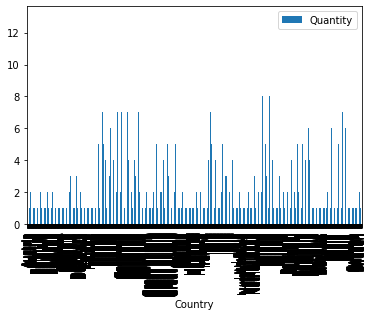

In [20]:

# ax = test.set_index('Gender').plot.pie(y='Quantity', x='Gender', figsize=(8, 8), title='Titulo')
# # fig = ax.get_figure()
# # fig.savefig('./data/reporting/gender_distribution.jpeg')
# ax

ax = test.plot.bar(x='Country')

In [ ]:
final['Percentage']=round(final['Quantity']/sum(final['Quantity'])*100,2)
# final['Percentage']
final

In [ ]:
display(final.sort_values('Job Title'))


In [ ]:
final['Percentage'] = final['Quantity'].apply(lambda x: x/sum(x))
final.head()

In [ ]:
# get_percentage = lambda x: count(x)/sum(x)
table_test[(table_test['Country']=="Belgium")&(table_test['Job Title']=="Data Scientist")]


In [ ]:
# test = table_test.groupby(['Country','Job Title','Gender']).agg(Quantity=('Job Title', 'count'))

tt = table_test[table_test['Country']=="Spain"]
test = tt.groupby(['Country','Job Title','Gender']).agg(Quantity=('Job Title', 'count'))
test['Percentage']=round(test['Quantity']/sum(test['Quantity'])*100,2)
test

In [ ]:
def analyze(df,country=None):
    print(country)
    if country:
        print("with country")
        filtered_df = df[df['Country']==country]
        test = filtered_df.groupby(['Country','Job Title','Gender']).agg(Quantity=('Job Title', 'count'))
        test['Percentage']=round(test['Quantity']/sum(test['Quantity'])*100,2)
        return test
    else:
        print("no country")
        test = df.groupby(['Country','Job Title','Gender']).agg(Quantity=('Job Title', 'count'))
        test['Percentage']=round(test['Quantity']/sum(test['Quantity'])*100,2)
        return test
    
t = analyze(table_test,'Austria')  
t

In [ ]:
 = df_country[['Gender', 'Quantity']].set_index('Gender').groupby('Gender').sum().reset_index()
    ax = g.set_index('Gender').plot.pie(y='Quantity', x='Gender', figsize=(8, 8), title=tit1)
    fig = ax.get_figure()
    fig.savefig('./data/reporting/gender_distribution.jpeg')


# Bonus 1

In [ ]:
url = '../data/raw/raw_data_project_m1.db'
# def get_data_from_sql(url):
#     sqlitedb_path = url
#     engine = create_engine(f'sqlite:///{sqlitedb_path}')
#     df_sql = pd.read_sql_query("SELECT  * FROM poll_info", engine)
#     dfsql.columns = ['uuid','awareness','votes','effect','for','against']
#     dfsql['count_for'] = dfsql['for'].apply(lambda x: len(x.split("|")))
#     dfsql['count_a'] = dfsql['against'].apply(lambda x: len(x.split("|")))
#     return df_sql

def get_poll_info(url):
#     cfg = configparser.RawConfigParser()
#     cfg.read('config.ini')
    sqlitedb_path = url
    engine = create_engine(f'sqlite:///{sqlitedb_path}')
    data = pd.read_sql_query("SELECT poll_info.question_bbi_2016wave4_basicincome_vote as 'Vote', \
                                poll_info.question_bbi_2016wave4_basicincome_argumentsfor as 'For', \
                                poll_info.question_bbi_2016wave4_basicincome_argumentsagainst as 'Against', \
                                country_info.country_code as 'Country' \
                                FROM poll_info\
                                JOIN country_info on poll_info.uuid = country_info.uuid", engine)
    data['n_args_for'] = data['For'].apply(lambda x: len(x.split("|")))
    data['n_args_against'] = data['Against'].apply(lambda x: len(x.split("|")))
    return data

dfsql = get_poll_info(url)

dfsql

In [ ]:
# df_agg = dfsql.groupby('votes').agg(yes=('count_for', 'mean'),no=('count_a', 'mean')).reset_index()

test = dfsql.groupby('count_for').size()

# tt = pd.DataFrame(test).T
# tt.iloc[1,1]
test


In [ ]:
#data agrupation
df_sql = dfsql
filteryes = (df_sql['Vote']=='I would vote for it')|(df_sql['Vote']=='I would probably vote for it')
filterno = (df_sql['Vote']=='I would vote against it')|(df_sql['Vote']=='I would probably vote against it')
df_sql.loc[filteryes, 'Vote'] = 'In Favor'
df_sql.loc[filterno, 'Vote'] = 'Against'

#data manipulation
df = df_agg[df_agg['Vote']!='I would not vote']
df_agg = df_sql.groupby(['Country','Vote']).agg(yes=('n_args_for', 'mean'),no=('n_args_against', 'mean')).reset_index()
df = df_agg[df_agg['Vote']!='I would not vote']
df = df.rename(columns={'yes':'Number of Pro Arguments','no':'Number of Cons Arguments'})
# df_agg.drop()
df
# df_agg = df_agg.drop('I would not vote')
# df_agg.columns = ['Number of Pro Arguments','Number of Cons Arguments']
# df_agg.reset_index()


In [ ]:
#data without agrupation
new_df = pd.DataFrame(df_sql.groupby('votes').size()).reset_index()
new_df['Quantity'] = new_df[0] 
new_df.drop(0)
new_df['Percentage'] = (new_df['Quantity']/new_df['Quantity'].sum())*100
new_df

In [ ]:
# df_sql.groupby('votes').describe().T
new_df[(new_df['votes']=='I would vote for it') | (new_df['votes']=='I would probably vote against it')]

# Bonus 2

In [ ]:
url = '../data/raw/raw_data_project_m1.db'


def get_skills(url):
    sqlitedb_path = url
    engine = create_engine(f'sqlite:///{sqlitedb_path}')
    df_sql = pd.read_sql_query("SELECT career_info.dem_education_level as 'Education Level', \
                                career_info.normalized_job_code as 'Job Code', \
                                country_info.country_code as 'Country'\
                                FROM career_info \
                                JOIN country_info on career_info.uuid = country_info.uuid", engine)
    df_sql['Country'] = df_sql['Country'].apply(get_country_name)
    return df_sql

df_sk = get_skills(url)
df_sk

In [ ]:
#drop null education
df_sk = df_sk.dropna(subset=['Education Level'])

#most repeated job
df_sk = df_sk.groupby(['Country','Job Code','Education Level']).size()
df_new = pd.DataFrame(df_sk)

df_new.sort_values(by=[0])
idx = df_new.groupby(['Education Level','Country'])[0].transform(max) == df_new[0]
df_new = df_new[idx].reset_index()
# df_new.sort_values(by=[0])
df_new[df_new['Country']=='Spain']

In [ ]:
def get_skills_names(x):
    x = str(x)
    response = requests.get(f'http://api.dataatwork.org/v1/jobs/{x}/related_skills')
    if response.status_code != 404:
        skill_raw = response.json()['skills']
        results = [x['skill_name'] for x in skill_raw[0:10]]
        return results
    else:
        skill_raw = ['No related skills']
        return skill_raw

df_new['Skills'] = df_new['Job Code'].apply(get_skills_names)
df_new

df1 = pd.DataFrame(df_new['Skills'].values.tolist(), columns=['Skill-'+str(x) for x in range(1,11)])
# final = pd.concat([df_new, df1] axis=1)
final = pd.concat([df_new['Education Level'].reset_index(drop=True), df1.reset_index(drop=True)], axis=1)
# df_new = pd.DataFrame(df_new['Skills'].tolist(), index= df_new.index)
# a  = get_skills_names('1a281bf4bd1fe9b2a6e464e508bea167')

In [ ]:
final

In [ ]:

df1 = pd.DataFrame(df_new['Skills'].values.tolist(), columns=['Skill-'+str(x) for x in range(1,11)])
# final = pd.concat([df_new, df1] axis=1)
final = pd.concat([df_new['Education Level'].reset_index(drop=True), df1.reset_index(drop=True)], axis=1)


In [ ]:
receiver_address = 'ma.rodenas@hotmail.com,marodenas6@gmail.com'
receiver_address = receiver_address.split(',')

In [ ]:
receiver_address